In [1]:
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sb
import csv
import os


%matplotlib inline

# Networks: structure, evolution & processes
**Internet Analytics - Lab 2**

---

**Group:** *Y*

**Names:**

* *Maateusz Paaluchowski*
* *Kristian Aurlien*

---

#### Instructions

*This is a template for part 1 of the lab. Clearly write your answers, comments and interpretations in Markodown cells. Don't forget that you can add $\LaTeX$ equations in these cells. Feel free to add or remove any cell.*

*Please properly comment your code. Code readability will be considered for grading. To avoid long cells of codes in the notebook, you can also embed long python functions and classes in a separate module. Don’t forget to hand in your module if that is the case. In multiple exercises, you are required to come up with your own method to solve various problems. Be creative and clearly motivate and explain your methods. Creativity and clarity will be considered for grading.*

---

## 2.1 Exploration of real networks

#### Exercise 2.1

In [9]:
DATA_PATH = '../data/'

def load_graph(network_name):
    file_path = os.path.join(DATA_PATH, network_name)
    with open(file_path) as f:
        data=[tuple(line) for line in csv.reader(f)]
        
    # Drop the two first rows, containing headers 
    edge_list = data[2:]
    
    graph = nx.Graph(edge_list)
    
    return graph


G1 = load_network('network1.csv')

In [10]:
def describe_graph(graph):
    print("Number of nodes:", graph.number_of_nodes())
    print("Number of edges:", graph.number_of_edges())
    
describe_graph(G1)

Number of nodes: 13033
Number of edges: 18584


#### Exercise 2.2:  Node degree distribution

In [102]:
def node_degree_distribution(graph):
    degrees = sorted(graph.degree().values(), reverse=True)
    cumulative_sum = np.cumsum(degrees)
    
    # TODO: Explain what this is
    # TODO: Fix axis?
    
    print("The maximum degree is", max(degrees))
    print("The average degree is {:.2f}".format(np.mean(degrees)))

    
    plt.figure(figsize=(10,5))
    plt.subplot(1, 2, 1)
    plt.loglog(degrees)
    plt.title("Degree rank plot")
    plt.ylabel("degree")
    plt.xlabel("rank")

    plt.subplot(1, 2, 2)
    plt.title("Cumulative frequency")
    plt.ylabel("sum")
    plt.xlabel("rank")
    plt.plot(cumulative_sum)
    plt.show()

The maximum degree is 1482
The average degree is 2.85


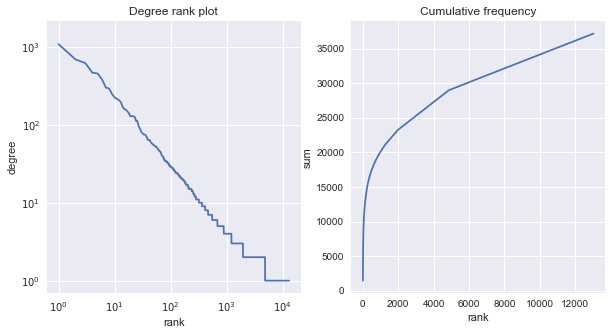

In [103]:
node_degree_distribution(G1)

We can see from the linear log-log plot that the node degree distribution follows a power law.

In [77]:
# TODO: Provide estimate for parameters of known distribution

#### Exercise 2.3: Giant component

In [78]:
def describe_connected_components(graph):
    # get the connected components
    ccomps = sorted(nx.connected_components(graph), \
                                  key = len, reverse=True)
    n_ccomps = len(ccomps)
    print("There are {} connected components in the graph\n".format(n_ccomps))
    
    # Calculate the sizes of the connected components
    ccomp_sizes = list(map(lambda x: len(x), ccomps))
    
    above_limit = len(ccomp_sizes) > 15
    
    if len(ccomp_sizes) > 15:
        print("The sizes of the 15 biggest connected components are:")
    else:
        print("The sizes of the connected components are:")
    print(ccomp_sizes[:15])

In [79]:
describe_connected_components(G1)

There are 192 connected components in the graph

The sizes of the 15 biggest connected components are:
[12576, 16, 7, 6, 5, 5, 5, 4, 4, 4, 4, 4, 4, 4, 3]


We observe one giant component in the graph, which is of size 12576

#### Exercise 2.4: Short paths & Small-worlds

In [70]:
def small_world(graph):
    ccomps = sorted(nx.connected_components(graph), \
                                  key = len, reverse=True)
    
    giant_component = graph.subgraph(ccomps[0])
    avg_shortest_paths = nx.average_shortest_path_length(giant_component)
    
    print("The average shortest path is", avg_shortest_paths)

In [ ]:
small_world(G1)

#### Exercise 2.5: Network comparison

In [73]:
G2 = load_network('network2.csv')

In [74]:
describe_network(G2)

Number of nodes: 26542
Number of edges: 43516


The maximum degree is 8
The average degree is 3.28


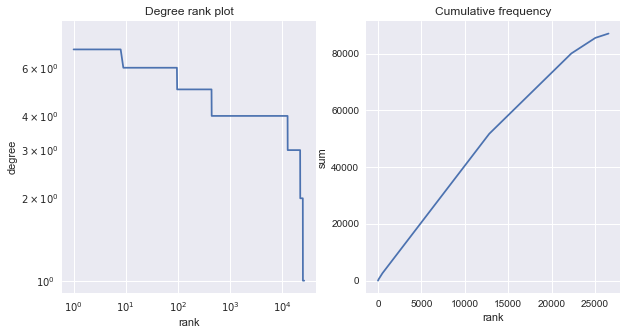

In [105]:
node_degree_distribution(G2)

In [76]:
describe_connected_components(G2)

There are 5 connected components in the graph

The sizes of the 15 biggest components are:
[26481, 30, 24, 5, 2]


In [ ]:
small_world(G2)

#### Exercise 2.6: Network identification

In the first network, the highest degree of a node is 1482, while in the second network the highest degree is 8. It is therefore reasonable to expect the second one to be the New York road network, and that the first network is the internet routers.